# Predicting tennis outcomes

### Import Libraries

In [55]:
import pandas as pd
import numpy as np
import random #Generating random numbers
from datetime import datetime #Working with time data
import matplotlib.pyplot as plt # Plot library 1
import seaborn as sns #Plot library 2
import math

# Libraries for doing requests on ESPN
import requests
import json

# Machine Learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

### Import Datasets

In [10]:
#Players
players_df = pd.read_csv("atp_players.csv")
players_df["full_name"] = players_df["name_first"] + " " + players_df["name_last"]

#Newest Rankings - sorted
rankings_df = pd.read_csv("atp_rankings_current.csv")
newest_version = rankings_df.sort_values("ranking_date", ascending = False).loc[0,"ranking_date"]
rankings_df = rankings_df.loc[rankings_df["ranking_date"] == newest_version]
rankings_df = rankings_df.sort_values("rank", ascending = True, ignore_index=True)
rankings_df['ranking_date'] = pd.to_datetime(rankings_df['ranking_date'], format='%Y%m%d')

#Matches between 2001 and 2023
matches = pd.DataFrame()
for year in range(2001,2024):
  df = pd.read_csv("atp_matches_"+ str(year) +".csv")
  matches = matches.append(df)

matches.index = range(len(matches))
matches['tourney_date'] = pd.to_datetime(matches['tourney_date'], format='%Y%m%d')

#Surfaces
surfaces = {0:"Hard", 1: "Clay", 2: "Grass"}

### Define Classes

In [23]:
class Player:

    def __init__(self, full_name, age = None):
        self.name = full_name
        self.age = age
        self.id = int(players_df["player_id"].loc[players_df["full_name"] == full_name].values[0])
        self.nationality = players_df["ioc"].loc[players_df["full_name"] == full_name].values[0]
        self.hand = players_df["hand"].loc[players_df["full_name"] == full_name].values[0]
        self.height = players_df["height"].loc[players_df["full_name"] == full_name].values[0]
        self.n_wins = len(matches.loc[matches["winner_id"] == self.id].index)
        self.n_losses = len(matches.loc[matches["loser_id"] == self.id].index)
        self.total_matches = self.n_wins + self.n_losses
    
        #Winning Percentage
        if self.total_matches > 0:
            self.winning_percentage = self.n_wins/(self.total_matches)
        else:
            self.winning_percentage = ""

        #Best Surface
        try:
            wp_surfaces = list(map(self.get_winning_perc_per_surface,("Hard","Clay","Grass")))
            index_max = max(range(len(wp_surfaces)), key=wp_surfaces.__getitem__)
            self.best_surface = surfaces[index_max]
        except TypeError:
            self.best_surface = ""

    def get_current_ranking(self, current_date):
        ranking_data = rankings_df.loc[(rankings_df["player"] == self.id) & (rankings_df["ranking_date"] <= current_date)]
        ranking_data = ranking_data.sort_values(by="ranking_date", ascending=False)
        if not ranking_data.empty:
            return ranking_data.iloc[0]["rank"]
        else:
            return None
        
    
    def get_winning_perc_per_surface(self,surface):
        n_wins = len(matches.loc[(matches["surface"] == surface) & (matches["winner_id"] == self.id)].index)
        n_losses = len(matches.loc[(matches["surface"] == surface) & (matches["loser_id"] == self.id)].index)
        
        if (n_wins+n_losses) > 0:
            return(n_wins/(n_wins+n_losses))
        else:
            return 0


    def get_head_to_head_winning_perc(self,opponent):
        opponent_id = Player(opponent).id
        n_wins = len(matches.loc[(matches["winner_id"] == self.id) &
                                 (matches["loser_id"] == opponent_id)].index)
        n_losses = len(matches.loc[(matches["loser_id"] == self.id) &
                                   (matches["winner_id"] == opponent_id)].index)
        
        if (n_wins + n_losses) == 0:
            return 0.5
        else:
            return n_wins/(n_wins + n_losses)

    def get_aces_per_match(self):
        if self.total_matches != 0:
            aces_wins = matches["w_ace"].loc[matches["winner_id"] == self.id].sum()
            aces_losses = matches["l_ace"].loc[matches["loser_id"] == self.id].sum()
            return (aces_wins + aces_losses)/self.total_matches

    def get_double_faults_per_match(self):
        if self.total_matches != 0:
            df_wins = matches["w_df"].loc[matches["winner_id"] == self.id].sum()
            df_losses = matches["l_df"].loc[matches["loser_id"] == self.id].sum()
            return (df_wins + df_losses)/self.total_matches
        
        else:
            return 0

    def calculate_win_percentage_last_3_months(self, gameday):
        #gameday = pd.to_datetime(str(gameday), format='%Y%m%d')

        # Calculate the start date of the 3-month period
        three_months_ago = gameday - pd.DateOffset(months=3)

        # Filter matches DataFrame to include only matches played in the last 3 months
        mask = (matches['tourney_date'] >= pd.Timestamp(three_months_ago)) & (matches['tourney_date'] <= pd.Timestamp(gameday))
        player_matches = matches[(matches['winner_id'] == self.id) | (matches['loser_id'] == self.id)][mask]

        # Calculate number of games won and lost by player
        games_won_last_3_months = len(player_matches[player_matches['winner_id'] == self.id])
        games_lost_last_3_months = len(player_matches[player_matches['loser_id'] == self.id])

        # Calculate win percentage
        total_games_last_3_months = games_won_last_3_months + games_lost_last_3_months
        win_percentage = games_won_last_3_months / total_games_last_3_months if total_games_last_3_months > 0 else None

        return win_percentage
    
    def summary(self, suffix=''):
        data = {
                f"Player{suffix}": [self.name],
                f"Age{suffix}": [self.age],
                f"Winning %{suffix}": [self.winning_percentage],
                f"Avg. Aces/Match{suffix}": [self.get_aces_per_match()],
                f"Avg. Double Faults/Match{suffix}": [self.get_double_faults_per_match()],
                f"Best Surface{suffix}": [self.best_surface],
                f"Winning % last 3 months{suffix}": [self.calculate_win_percentage_last_3_months(datetime.today())]
            }

        return pd.DataFrame(data)

In [34]:
class Match:
    
    def __init__(self, match_string):
        self.match_string = match_string
        
        # Separar los nombres de los jugadores
        self.player1_name, self.player2_name = match_string.split(" - ")
        
        # Crear instancias de la clase Player para cada jugador
        self.player1 = Player(self.player1_name)
        self.player2 = Player(self.player2_name)
        
        
    def run_model(self,surface):
        #Ranking attributes
        self.ranking1 = self.player1.get_current_ranking(datetime.today())
        self.ranking2 = self.player1.get_current_ranking(datetime.today())
        self.log_rank_diff = np.log(self.ranking1) - np.log(self.ranking2)
        
        #H2H
        self.player_1_H2H_winning_perc = self.player1.get_head_to_head_winning_perc(self.player2_name)
        
        #Surface
        self.surface = surface_mapping[surface]
        self.player1_surface_winning_perc = self.player1.get_winning_perc_per_surface(self.surface)
        self.player2_surface_winning_perc = self.player2.get_winning_perc_per_surface(self.surface)
        
        #Aces and double faults
        self.player1_aces_per_match = self.player1.get_aces_per_match()
        self.player2_aces_per_match = self.player1.get_aces_per_match()
        self.player1_double_faults_per_match = self.player1.get_double_faults_per_match()
        self.player2_double_faults_per_match = self.player2.get_double_faults_per_match()
        
        #Momentum
        self.player_1_last3months_winning_perc = self.player1.calculate_win_percentage_last_3_months(datetime.today())
        self.player_2_last3months_winning_perc = self.player2.calculate_win_percentage_last_3_months(datetime.today())
        
        
        self.result_vector = [[self.log_rank_diff, self.player_1_H2H_winning_perc, self.surface,
                              self.player1_surface_winning_perc,self.player2_surface_winning_perc,
                              self.player1_aces_per_match, self.player2_aces_per_match,
                              self.player1_double_faults_per_match, self.player2_double_faults_per_match,
                              self.player_1_last3months_winning_perc, self.player_2_last3months_winning_perc]]
        
        result = logreg.predict(pd.DataFrame(self.result_vector, columns = input_features))
            
    def predict_probabilities(self):
        t = logreg.intercept_ + np.dot(self.result_vector,np.transpose(logreg.coef_))
        p = 1/(1 + np.exp(-t))
        
        if p > 1/2:
            print(self.match_string,"----- Prediction:",self.player1_name, "wins with p=",p[0][0])
            
        else:
            print(self.match_string,"----- Prediction:",self.player2_name, "wins with p=", 1-p[0][0])

### Train ML-Model

In [17]:
# Define function for preparing data
def transform_matches_df(df):
    new_df = pd.DataFrame(columns=["log_rank_diff","player_1_H2H_winning_perc", "surface", "player_1_surface_winning_perc",
                                   "player_2_surface_winning_perc", "aces_1_per_match", "aces_2_per_match",
                                   "double_faults_1_per_match", "double_faults_2_per_match",
                                   "player_1_last3months_winning_perc","player_2_last3months_winning_perc","player_1_wins"])

    for index, row in df.iterrows():
        if random.randint(0, 1) == 1:
            rank_1 = row["winner_rank"]
            rank_2 = row["loser_rank"]
            player_1 = row["winner_name"]
            player_2 = row["loser_name"]
            p1_wins = 1

        else:
            rank_1 = row["loser_rank"]
            rank_2 = row["winner_rank"]
            player_1 = row["loser_name"]
            player_2 = row["winner_name"]
            p1_wins = 0
        
        p1 = Player(player_1)
        p2 = Player(player_2)
        
        #Surface
        surface = row["surface"]
        
        #H2H winning percentage of Player 1
        player_1_H2H_winning_perc = p1.get_head_to_head_winning_perc(player_2)
        
        #Winning Percentage per Surface
        player_1_surface_winning_perc = p1.get_winning_perc_per_surface(surface)
        player_2_surface_winning_perc = p2.get_winning_perc_per_surface(surface)
        
        #Aces per match
        aces_1_per_match = p1.get_aces_per_match()
        aces_2_per_match = p2.get_aces_per_match()
        
        #Double Faults per match
        double_faults_1_per_match = p1.get_double_faults_per_match()
        double_faults_2_per_match = p2.get_double_faults_per_match()
        
        #Winning percentage last 3 months
        player_1_last3months_winning_perc = p1.calculate_win_percentage_last_3_months(row["tourney_date"])
        player_2_last3months_winning_perc = p2.calculate_win_percentage_last_3_months(row["tourney_date"])

        new_df = new_df.append({"log_rank_diff": np.log(rank_1) - np.log(rank_2),
                                "player_1_H2H_winning_perc": player_1_H2H_winning_perc,
                                "surface": surface,
                                "player_1_surface_winning_perc": player_1_surface_winning_perc,
                                "player_2_surface_winning_perc": player_2_surface_winning_perc,
                                "aces_1_per_match": aces_1_per_match,
                                "aces_2_per_match": aces_2_per_match,
                                "double_faults_1_per_match": double_faults_1_per_match,
                                "double_faults_2_per_match": double_faults_2_per_match,
                                "player_1_last3months_winning_perc": player_1_last3months_winning_perc,
                                "player_2_last3months_winning_perc": player_2_last3months_winning_perc,
                                "player_1_wins": p1_wins}, ignore_index=True)

    return new_df

In [53]:
# Tomemos 700 partidos
np.random.seed(0)
random_index = np.random.randint(low = 0, high = len(matches) - 1, size = 2500)
df = transform_matches_df(matches.loc[random_index])

C:\Users\marianocarmona\AppData\Local\miniconda\envs\v37\lib\site-packages\ipykernel_launcher.py:82: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [54]:
#Map categorical variable 'surface' to integer values
surface_mapping = {'Hard': 0, 'Clay': 1, 'Grass': 2, 'Carpet': 3}
df['surface'] = df['surface'].replace(surface_mapping)


# Define the input features and the target attribute
input_features = ["log_rank_diff","player_1_H2H_winning_perc", "surface", "player_1_surface_winning_perc",
                                   "player_2_surface_winning_perc", "aces_1_per_match", "aces_2_per_match",
                                   "double_faults_1_per_match", "double_faults_2_per_match",
                                   "player_1_last3months_winning_perc","player_2_last3months_winning_perc"]

output_feature = "player_1_wins"

#Filter out NAs
df = df.dropna()
df.head()

,log_rank_diff,player_1_H2H_winning_perc,surface,player_1_surface_winning_perc,player_2_surface_winning_perc,aces_1_per_match,aces_2_per_match,double_faults_1_per_match,double_faults_2_per_match,player_1_last3months_winning_perc,player_2_last3months_winning_perc,player_1_wins
0,-0.648297,1.000000,0,0.426230,0.367925,3.202532,2.270270,3.813291,2.054054,0.500000,0.333333,1
1,0.619039,0.333333,2,0.350000,0.395833,8.862434,9.122977,3.624339,3.333333,0.555556,0.300000,0
2,0.853112,0.200000,1,0.492147,0.497872,3.576531,1.614251,1.747449,3.201474,0.500000,0.470588,0
3,-1.585145,1.000000,1,0.533981,0.350000,0.684864,4.675325,2.267990,4.584416,0.666667,0.285714,1
4,-1.822296,1.000000,1,0.548000,0.250000,3.539726,3.125000,3.378082,3.875000,0.588235,0.500000,1


In [56]:
le = LabelEncoder()


# Split the transformed dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop("player_1_wins", axis=1),
                                                    pd.Series(df["player_1_wins"]),
                                                    test_size=0.2,
                                                    random_state=42)


y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

# Train a logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logreg.predict(X_test)
print("Training set score: {:.3f}".format(logreg.score(X_train,y_train)))
print("Test set score: {:.3f}".format(logreg.score(X_test,y_test)))

# Fit the logistic regression model
logit_model = sm.Logit(y_train, X_train)
result = logit_model.fit()

# Get the summary table
summary = result.summary2()

# Print the summary table
print(summary)

Training set score: 0.871
Test set score: 0.889
Optimization terminated successfully.
         Current function value: 0.269914
         Iterations 8
                                 Results: Logit
Model:                     Logit                 Pseudo R-squared:      0.610    
Dependent Variable:        y                     AIC:                   1071.4253
Date:                      2023-03-13 12:19      BIC:                   1132.7228
No. Observations:          1944                  Log-Likelihood:        -524.71  
Df Model:                  10                    LL-Null:               -1346.5  
Df Residuals:              1933                  LLR p-value:           0.0000   
Converged:                 1.0000                Scale:                 1.0000   
No. Iterations:            8.0000                                                
---------------------------------------------------------------------------------
                                   Coef.  Std.Err.    z    P>|z|

### Visualize results of the model

Accuracy: 0.89419795221843


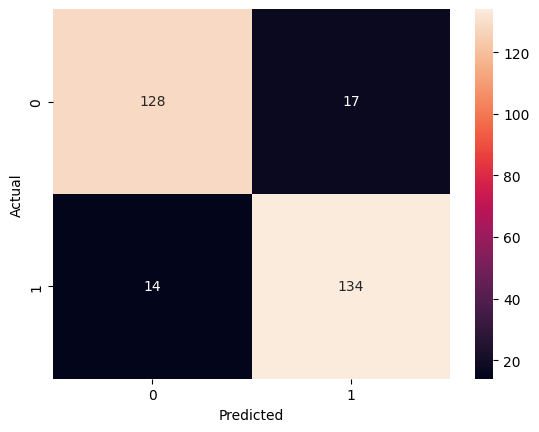

In [39]:
# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

#Confusion matrix
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Get data from ESPN website

In [41]:
# Hacemos una solicitud a la API de tenis de ESPN
response = requests.get('https://site.api.espn.com/apis/site/v2/sports/tennis/atp/scoreboard')

# Verificamos si la solicitud fue exitosa
if response.status_code == 200:
    # Obtenemos la información de los partidos
    data = response.json()['events']
    
    # Guardamos el archivo json
    with open('datos.json', 'w') as archivo:
        json.dump(data, archivo)
    print("El archivo se ha guardado con éxito")

else:
    # Si la solicitud no fue exitosa, mostramos un mensaje de error
    print("Error al obtener los partidos. Código de estado: ", response.status_code)

El archivo se ha guardado con éxito


In [42]:
# Obtenemos la información de los partidos
with open('datos.json') as archivo:
    data = json.load(archivo)

# Recorremos cada partido y mostramos el nombre de los jugadores si el partido es programado para hoy
l_matches = []
for i in range(len(data[0]["competitions"])):
    if data[0]["competitions"][i]["status"]["type"]["completed"] == False:
        try:
            Player_1 = data[0]["competitions"][i]["competitors"][0]['athlete']["fullName"]
            Player_2 = data[0]["competitions"][i]["competitors"][1]['athlete']["fullName"]
            l_matches += [Player_1 + " - " + Player_2]
        except KeyError:
            pass

#Elimino a los partidos que todavia no tienen confirmados a sus jugadores
l_matches = [p for p in l_matches if "TBD" not in p]

#Jaja aguanten Aliassime y Wawrinka
l_matches = [p.replace("Auger-Aliassime","Auger Aliassime") if "Auger-Aliassime"  in p else p for p in l_matches]
l_matches = [p.replace("Stanislas","Stan") if "Stanislas Wawrinka" in p else p for p in l_matches]

In [44]:
#Predicting today's matches
for game in l_matches:
    m = Match(game)
    m.run_model("Hard")
    m.predict_probabilities()

C:\Users\marianocarmona\AppData\Local\miniconda\envs\v37\lib\site-packages\ipykernel_launcher.py:82: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\marianocarmona\AppData\Local\miniconda\envs\v37\lib\site-packages\ipykernel_launcher.py:82: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\marianocarmona\AppData\Local\miniconda\envs\v37\lib\site-packages\ipykernel_launcher.py:82: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Cristian Garin - Casper Ruud ----- Prediction: Cristian Garin wins with p= 0.794821967941013
Francisco Cerundolo - Felix Auger Aliassime ----- Prediction: Felix Auger Aliassime wins with p= 0.9489403067167985
Hubert Hurkacz - Tommy Paul ----- Prediction: Hubert Hurkacz wins with p= 0.9745165426756304


C:\Users\marianocarmona\AppData\Local\miniconda\envs\v37\lib\site-packages\ipykernel_launcher.py:82: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\marianocarmona\AppData\Local\miniconda\envs\v37\lib\site-packages\ipykernel_launcher.py:82: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Stan Wawrinka - Holger Rune ----- Prediction: Holger Rune wins with p= 0.9410297629970711
Jannik Sinner - Adrian Mannarino ----- Prediction: Jannik Sinner wins with p= 0.9858129263256851


C:\Users\marianocarmona\AppData\Local\miniconda\envs\v37\lib\site-packages\ipykernel_launcher.py:82: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\marianocarmona\AppData\Local\miniconda\envs\v37\lib\site-packages\ipykernel_launcher.py:82: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\marianocarmona\AppData\Local\miniconda\envs\v37\lib\site-packages\ipykernel_launcher.py:82: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Alex Molcan - Marton Fucsovics ----- Prediction: Marton Fucsovics wins with p= 0.5240059498100682
Taylor Fritz - Sebastian Baez ----- Prediction: Taylor Fritz wins with p= 0.9882167265545495
Jack Draper - Andy Murray ----- Prediction: Jack Draper wins with p= 0.6073228451072663
Carlos Alcaraz - Tallon Griekspoor ----- Prediction: Carlos Alcaraz wins with p= 0.9804584915265814


C:\Users\marianocarmona\AppData\Local\miniconda\envs\v37\lib\site-packages\ipykernel_launcher.py:82: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\marianocarmona\AppData\Local\miniconda\envs\v37\lib\site-packages\ipykernel_launcher.py:82: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Frances Tiafoe - Alejandro Tabilo ----- Prediction: Frances Tiafoe wins with p= 0.950809509309861
Andrey Rublev - Cameron Norrie ----- Prediction: Andrey Rublev wins with p= 0.6992980519263602


C:\Users\marianocarmona\AppData\Local\miniconda\envs\v37\lib\site-packages\ipykernel_launcher.py:82: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
C:\Users\marianocarmona\AppData\Local\miniconda\envs\v37\lib\site-packages\ipykernel_launcher.py:82: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Alejandro Davidovich Fokina - Cristian Garin ----- Prediction: Alejandro Davidovich Fokina wins with p= 0.720443827006791
Daniil Medvedev - Alexander Zverev ----- Prediction: Daniil Medvedev wins with p= 0.8794657473154471


C:\Users\marianocarmona\AppData\Local\miniconda\envs\v37\lib\site-packages\ipykernel_launcher.py:82: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


### Getting bet data from Tipico

In [59]:
#Import Selenium
from selenium import webdriver
import pandas as pd
import time

#Writing our First Selenium Python Test
web = 'https://sports.tipico.de/en/all/football/spain/la-liga' #you can choose any other league (update 1)
path = '/Users/.../chromedriver'
driver = webdriver.Chrome(path)
driver.get(web)

#Make ChromeDriver click a button
time.sleep(5) #add implicit wait, if necessary
accept = driver.find_element_by_xpath('//*[@id="_evidon-accept-button"]')
accept.click()

#Initialize your storage
teams = []
x12 = [] #3-way
odds_events = []

#scroll down to the bottom to load upcoming matches (update 2: not necessary anymore)
#driver.execute_script("window.scrollTo(0, document.body.scrollHeight)")
#time.sleep(3) #add implicit wait to let the driver load the elements of the upcoming matches section.

#select only upcoming matches box
box = driver.find_element_by_xpath('//div[contains(@testid, "Program_SELECTION")]') #update 3
#Looking for 'sports titles'
sport_title = box.find_elements_by_class_name('SportTitle-styles-sport')

for sport in sport_title:
    # selecting only football
    if sport.text == 'Football':
        parent = sport.find_element_by_xpath('./..') #immediate parent node
        grandparent = parent.find_element_by_xpath('./..') #grandparent node = the whole 'football' section
        #Looking for single row events
        single_row_events = grandparent.find_elements_by_class_name('EventRow-styles-event-row')
        #Getting data
        for match in single_row_events:
            #'odd_events'
            odds_event = match.find_elements_by_class_name('EventOddGroup-styles-odd-groups')
            odds_events.append(odds_event)
            # Team names
            for team in match.find_elements_by_class_name('EventTeams-styles-titles'):
                teams.append(team.text)
        #Getting data: the odds        
        for odds_event in odds_events:
            for n, box in enumerate(odds_event):
                rows = box.find_elements_by_xpath('.//*')
                if n == 0:
                    x12.append(rows[0].text)

driver.quit()
#Storing lists within dictionary
dict_gambling = {'Teams': teams, '1x2': x12}
#Presenting data in dataframe
df_gambling = pd.DataFrame.from_dict(dict_gambling)
print(df_gambling)

C:\Users\marianocarmona\AppData\Local\miniconda\envs\v37\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  if __name__ == "__main__":


AttributeError: 'WebDriver' object has no attribute 'find_element_by_xpath'